# Sentinel-2 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
    * One step of the analysis ('Sentinel-2 Near Real Time') is currently only compatible with the DEA Sandbox
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule)


## Background

Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands).
The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery.
Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import sys
import datacube
from odc.ui import with_ui_cbk

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_bandindices import calculate_indices
from dea_spatialtools import subpixel_contours

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Vegetation lines")

## Load Sentinel-2 data from the datacube

We will load **Sentinel-2 Definitive** data from the Sentinel-2A and Sentinel-2B satellites using two methods.
Firstly, we will use [dc.load()](../Beginners_guide/04_Loading_data.ipynb) to return a time series of satellite images from a single sensor.
Secondly, we will load a time series using the [load_ard()](../Frequently_used_code/Using_load_ard.ipynb) function, which is a wrapper function around the dc.load module.
This function will load all the images from both Sentinel-2A and Sentinel-2B, combine them, and then apply a cloud mask.
The returned `xarray.Dataset` will contain analysis ready images with the cloudy and invalid pixels masked out.

You can change any of the parameters in the `query` object below to adjust the location, time, projection, or spatial resolution of the returned datasets.
To learn more about querying, refer to the Beginner's guide notebook on [loading data](../Beginners_guide/04_Loading_data.ipynb).

Sentinel-2 data is stored on file with a range of different coordinate reference systems or CRS (i.e. multiple UTM zones). 
The different satellite bands also have different resolutions (10 m, 20 m and 60 m). 
Because of this, all Sentinel-2 queries need to include the following two query parameters:

* `output_crs`: This sets a consistent CRS that all Sentinel-2 data will be reprojected to, regardless of the UTM zone the individual image is stored in.
* `resolution`: This sets the resolution that all Sentinel-2 images will be resampled to. 

> **Note:** Be aware that setting `resolution` to the highest available resolution (i.e. `(-10, 10)`) will downsample the coarser resolution 20 m and 60 m bands, which may introduce unintended artefacts into your analysis.
It is typically best practice to set `resolution` to match the lowest resolution band being analysed. For example, if your analysis uses both 10 m and 20 m resolution bands, set `"resolution": (-20, 20)`.

In [3]:
# Two Rocks
top, left = -31.49986, 115.58059
bottom, right = -31.53129, 115.61059


### Load Sentinel-2 using `dc.load()`

The two **Sentinel-2 Definitive** products are:

* `s2a_ard_granule`
* `s2b_ard_granule`

Here we will load in a time-series of satellite images from only Sentinel-2A.
To load in images from Sentinel-2B, change the `product` variable to `'s2b_ard_granule'`.

In [ ]:
# Create a query object
query = {
    "x": (left, right),
    "y": (top, bottom),
    "time": ("2017", "2020"),
    "output_crs": "EPSG:32650",
    "resampling": {
        'fmask': 'nearest',
        'oa_fmask': 'nearest',
        'nbart_contiguity': 'nearest',
        'oa_nbart_contiguity': 'nearest',
        '*': 'cubic'
    },
    "resolution": (-10, 10),
    "group_by": "solar_day",
    "dask_chunks": {}
}

ds = load_ard(dc=dc, 
              products=['s2a_ard_granule', 's2b_ard_granule'],
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 
                           'nbart_red_edge_1', 'nbart_red_edge_2', 
                           'nbart_red_edge_3', 'nbart_nir_1', 'nbart_nir_2', 
                           'nbart_swir_2', 'nbart_swir_3'],
              **query)

print(ds)

ndvi = calculate_indices(ds, index=['MNDWI', 'NDVI'], collection='ga_s2_1', drop=True)

In [4]:
# Create a query object
query = {
    "x": (left, right),
    "y": (top, bottom),
    "time": ("1988", "2020"),
    "output_crs": "EPSG:32650",
    "resampling": {
        'fmask': 'nearest',
        'oa_fmask': 'nearest',
        'nbart_contiguity': 'nearest',
        'oa_nbart_contiguity': 'nearest',
        '*': 'cubic'
    },
    "resolution": (-30, 30),
    "group_by": "solar_day",
    "dask_chunks": {}
}

ds = load_ard(dc=dc, 
#               skip_broken_datasets=True,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              measurements=['nbart_green', 'nbart_red', 'nbart_nir', 'nbar_swir_1'],
              **query)

ds = ds.sel(time=(ds.time.dt.year.isin([1988, 1990, 1996, 2004, 2008, 2011, 2016])))
ndvi = calculate_indices(ds, index=['MNDWI', 'NDVI'], collection='ga_ls_3', drop=True)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 1557 time steps as a dask array
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'oa_nbart_contiguity', 'oa_azimuthal_exiting', 'oa_azimuthal_incident', 'oa_combined_terrain_shadow', 'oa_exiting_angle', 'oa_incident_angle', 'oa_relative_azimuth', 'oa_relative_slope', 'oa_satellite_azimuth', 'oa_satellite_view', 'oa_solar_azimuth', 'oa_solar_zenith', 'oa_time_delta', 'oa_fmask']


In [39]:
ds_masked = ndvi.NDVI.where((ndvi.MNDWI < 0), 0).where(~ndvi.MNDWI.isnull())


In [40]:
out = ds_masked.groupby(ds_masked.time.dt.year).median().compute()

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))


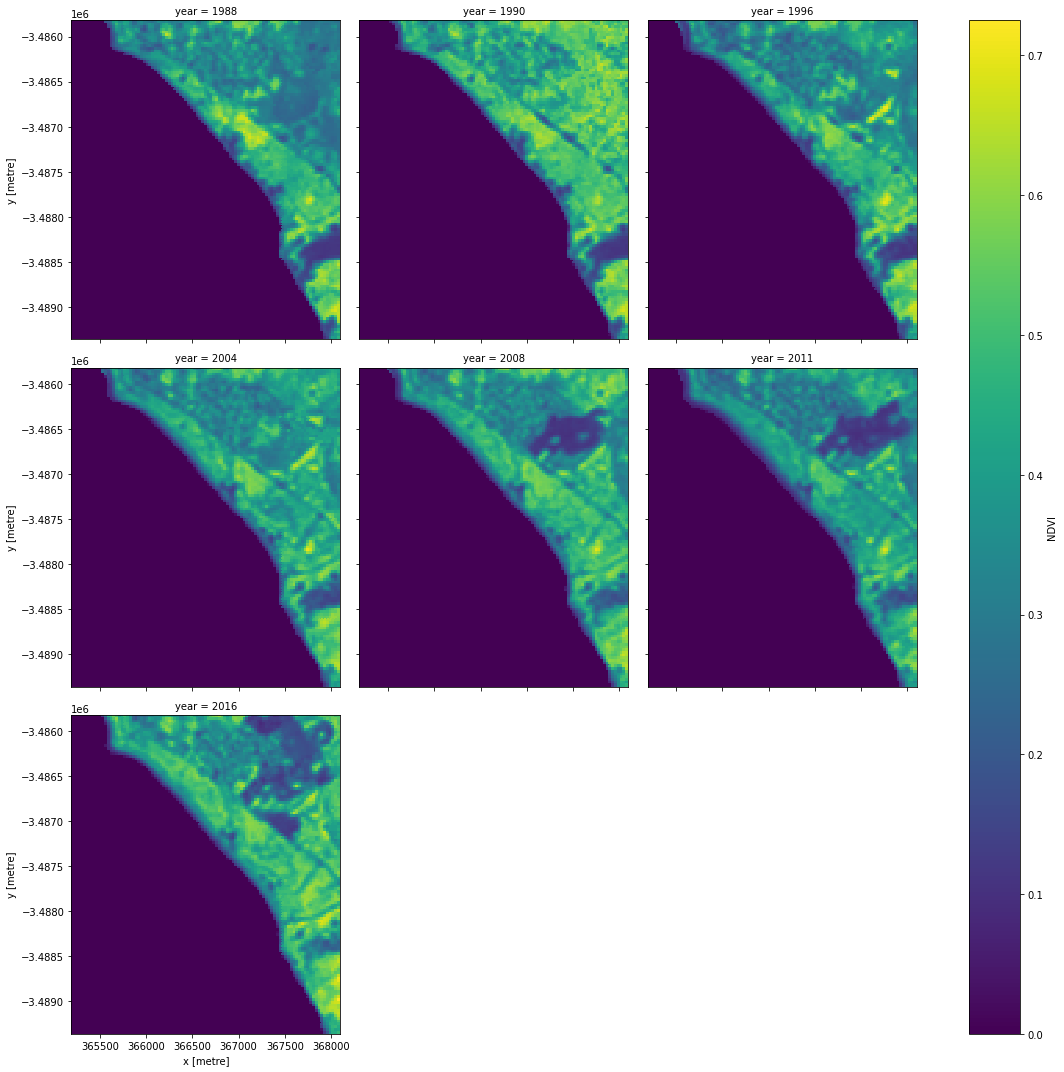

In [41]:
out.plot(col='year', size=5, col_wrap=3)

In [42]:
from skimage import feature, filters, morphology
import matplotlib.pyplot as plt

def veg_line_mask(da, guassian=1, canny=3, dilation=4):    

    array = da.fillna(0).values
    array = filters.gaussian(array, sigma=guassian)
    canny_ds = feature.canny(array, sigma=canny)
    dilated_ds = morphology.binary_dilation(canny_ds, morphology.disk(dilation))
    return dilated_ds

veg_mask = out.groupby('year').apply(veg_line_mask)

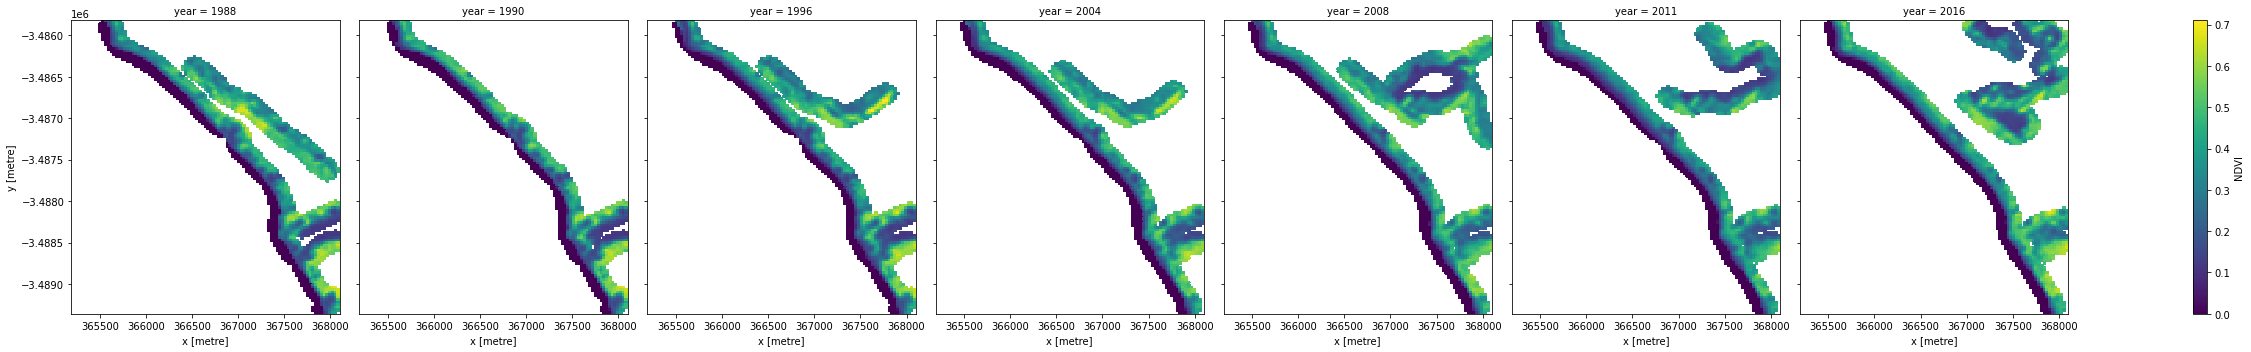

In [43]:
out_masked = out.where(veg_mask) 
out_masked.plot(col='year', size=5)

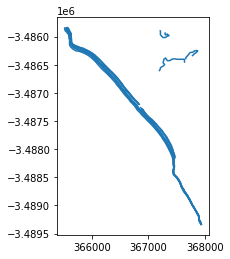

In [45]:
lines = subpixel_contours(out_masked, z_values=0.12, dim='year', crs = ds.geobox.crs, affine = ds.geobox.transform, output_path='test.geojson', min_vertices=20)
lines.plot()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)